In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import pickle


from src.models.decision_transformer import DecisionTransformer
from src.data.dataset import RecommendationDataset
from src.training.trainer import *


import numpy as np
import torch as T
from torch.utils.data import random_split, DataLoader

# Set up device
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    T.manual_seed(seed)
    if T.cuda.is_available():
        T.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda


# Entrenamiento de DT4REC

En este notebook se implementa un pipeline de entrenamiento de un Transformer de Decisiones (DT) para predecir recomendaciones partiendo de un dataset de Netflix.

### Carga de trayectorias

Se cargan las trayectorias previamente preprocesadas. 

Se tienen dos archivos de trayectoria uno con las recompensas normalizadas ('data/processed/normalized_trajectories_train.pkl') y otro con las recompensas sin normalizar (data/processed/trajectories_train.pkl). 

In [2]:

load_normalized_trayectories = False

if load_normalized_trayectories:
    with open('../data/processed/normalized_trajectories_train.pkl', 'rb') as f:
        trajectories = pickle.load(f)
else:
    with open('../data/processed/trajectories_train.pkl', 'rb') as f:
        trajectories = pickle.load(f)

### Configuración de Híper-parámetros.

Se realizaron algunas pruebas sobre distintos conjuntos de híper-parámetros. Finalmente, estos fueron los que proveyeron mejores resultados:

In [3]:
# Hyperparameters
num_items = 752
num_groups = 8
hidden_dim = 512
n_layers = 2
n_heads = 4
context_length = 20
max_timesteps = 200
dropout = 0.05
batch_size = 32
num_epochs = 200
learning_rate = 0.0001

### Inicialización del modelo

Con los híper-parámetros elegidos, se instancia la clase `DecisionTransformer` que contiene el modelo a entrenar

In [4]:
# Inicialización del modelo
model = DecisionTransformer(
    num_items=num_items,
    num_groups=num_groups,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to(device)

# Número de parámetros del modelo
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 7,570,672


### Preparación de datos para entrenamiento

Usando `RecommendationDataset` construimos el conjunto de datos en el formato admitido por el Decision Transformer. Como resultado, se obtiene un diccionario con tensores para 'states', 'actions', 'rtg', 'timesteps', 'groups' y 'targets'.

En esta instancia separamos un subconjunto para validación. Seteamos el tamaño en un 20% del dataset completo.


In [5]:
dataset = RecommendationDataset(trajectories=trajectories, context_length=context_length)
print(dataset.trajectories[0])

print(f"Number of training trajectories: {len(trajectories)}")
print(dataset)

val_ratio = 0.01 # porcentaje de datos para validación
train_ratio = 1 - val_ratio

n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,        # siempre validamos sobre la misma secuencia
    num_workers=0
)

print("\nDataset details:")
print(f"Dataset train size: {len(train_dataset)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Dataset val size: {len(val_dataset)}")
print(f"Batches per epoch (val): {len(val_loader)}")

# Para testear los shapes de los batches
# sample_batch = next(iter(train_loader))
# print(f"\nSample batch shapes:")
# for key, val in sample_batch.items():
#     print(f"  {key}: {val.shape}")

# Nueva celda para debug
sample_batch = next(iter(train_loader))
states = sample_batch['states'].to(device)
actions = sample_batch['actions'].to(device)
rtg = sample_batch['rtg'].to(device)
timesteps = sample_batch['timesteps'].to(device)
groups = sample_batch['groups'].to(device)

print(f"rtg shape antes de embedding: {rtg.shape}, dtype: {rtg.dtype}")
print(f"rtg_embedding input shape: {rtg.shape}")

# Test embedding manual
rtg_test = model.rtg_embedding(rtg)
print(f"rtg_emb shape después de embedding: {rtg_test.shape}")
print(f"rtg_emb ndim: {rtg_test.ndim}")

# Verifica qué es rtg_embedding
print(f"rtg_embedding layer: {model.rtg_embedding}")


{'items': array([472,  97, 122, 654, 709, 467, 574, 544, 478, 338, 301, 185, 156,
       712, 525, 225, 396, 370, 589, 750, 586, 353, 416, 687, 465, 433,
       215, 438, 219, 528, 134, 444,  92,  24, 145, 572,  22, 454, 715,
       364,  19, 115, 386, 374, 203, 229,  44, 624, 303, 152, 206, 268,
       329, 692,   8,  12, 291, 633, 537, 457, 121, 689, 164, 114, 566,
       519, 234, 154, 104,  74,  49,  86, 419, 315, 387, 663, 400]), 'ratings': array([4., 3., 4., 3., 5., 4., 2., 1., 4., 5., 5., 3., 4., 4., 4., 2., 5.,
       5., 5., 4., 4., 3., 4., 5., 1., 1., 5., 4., 4., 4., 4., 4., 4., 5.,
       2., 4., 5., 3., 4., 3., 2., 1., 5., 3., 4., 4., 3., 5., 4., 5., 4.,
       5., 4., 3., 4., 4., 5., 5., 3., 2., 4., 5., 5., 5., 2., 5., 5., 2.,
       4., 5., 4., 5., 4., 5., 4., 3., 5.]), 'returns_to_go': array([296., 292., 289., 285., 282., 277., 273., 271., 270., 266., 261.,
       256., 253., 249., 245., 241., 239., 234., 229., 224., 220., 216.,
       213., 209., 204., 203., 202., 197.,

In [6]:
optimizer = T.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

El código comentado en la celda siguiente permite entrenar el modelo. Dados los largos tiempos de entrenamiento, usamos el script `training.py` que permite ejecutar en una terminal en background. A continuación, cargamos los resultados previamente guardados y los comparamos con los obtenidos con código de referencia.

In [7]:

# model, history = train_decision_transformer(
#     model,
#     train_loader,
#     val_loader,
#     optimizer,
#     device,
#     num_epochs=200,
#     checkpoint_dir="checkpoints"
# )


Graficamos los resultados de las pérdidas de entrenamiento y validación del código refactoreado y el de referencia.

In [8]:
with open('../results/training_histories/training_history_refactored.pkl', 'rb') as f:
    history = pickle.load(f)

with open('../results/training_histories/training_history_reference.pkl', 'rb') as f:
    history_reference = pickle.load(f)

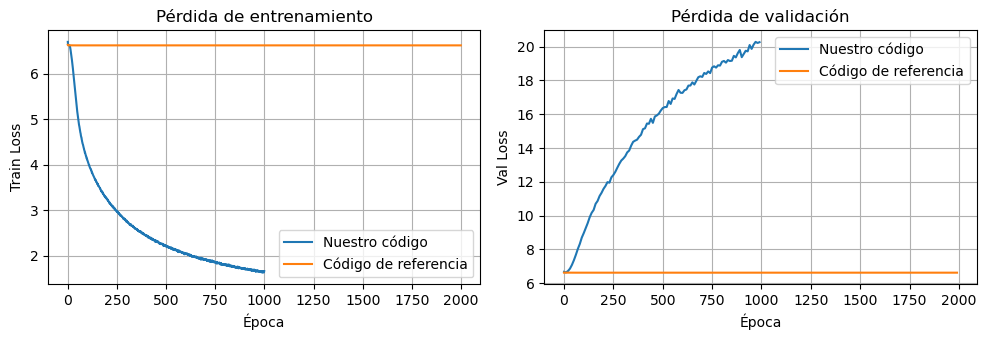

In [9]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(10,3.5))

# --- Train Loss  ---
axes[0].plot(history['train_loss'], label='Nuestro código')
axes[0].plot(history_reference['train_loss'], label='Código de referencia')
axes[0].set_title('Pérdida de entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Train Loss')
axes[0].legend()
axes[0].grid(True)

# --- Validation Loss ---
axes[1].plot(np.arange(0,1000,10), history['val_loss'], label='Nuestro código')
axes[1].plot(np.arange(0,2000,10), history_reference['val_loss'], label='Código de referencia')
axes[1].set_title('Pérdida de validación')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Val Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../results/loss_comparison_refactored_vs_reference.png', dpi=300)
plt.show()
